In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib
from matplotlib.pyplot import xlabel, ylabel, title, show
import random
import math
from scipy.stats import expon, uniform, norm
import statistics
import holoviews


# objective = model biomass growth over a season and under irregular weather patterns

# germination parameters
initial_kernels = 1000   # corn kernels / acre
germ_period_min = 7      # days
germ_period_max = 21     # days
kernel_mean_loss = .06
acceptable_min_soil_precip = 0.08   # daily inches

# general model parameters and list initializations
num_simulations = 1000
viable_kernels_list = []
germination_mean_list = []
germination_rate_list = []
germination_biomass_list = []
temperature_mean_list = []
daily_precipitation_mean_list = []
final_biomass_list = []
season_biomass_list = []


# generates randomized values to model kernel loss
kernel_loss_list = expon.rvs(scale = kernel_mean_loss, size = num_simulations)


# class Condition is blueprint for creating objects that represent a specific growing season condition and its attributes
class Condition():
    def __init__(self, name, temp_lowerbound, temp_upperbound, precip_lowerbound, precip_upperbound, germ_temp_factor, germ_precip_factor):
      self.name = name
      self.temp_lowerbound = temp_lowerbound
      self.temp_upperbound = temp_upperbound
      self.precip_lowerbound = precip_lowerbound
      self.precip_upperbound = precip_upperbound
      self.germ_temp_factor = germ_temp_factor
      self.germ_precip_factor = germ_precip_factor


# defines conditions based on daily values and assigns temp and precipitation factor for germination
tempconditionlist = [Condition("Late Frost", 50, 70, 0.05, .1, .8, 0.8),
                     Condition("Severe Drought", 60, 110, .04, .12, .9, .6),
                     Condition("Moderate Drought", 60, 100, .08, .13, .95, .65),
                     Condition("Optimal Temps / Low Precip", 60, 86.9, .11, .18, 0.99, .88),
                     Condition("Optimal Temps / Optimal Precip", 60, 86.9, .175, .225, 1, 1),
                     Condition("High Temps / High Precip", 80, 100, .175, .263, .92, .96),
                     Condition("Flood", 60, 100, .175, .313, .95, 0.46)
                     ]


RANDOM_WEATHER_CONDITION = random.choice(tempconditionlist)    # a weather pattern / condition is randomized
GERMINATION_LIST_SIZE = 21

print("Total initial corn kernels per acre / per harvest season: " + str(initial_kernels))
print("Condition during germination: " + str(RANDOM_WEATHER_CONDITION.name))



# Simulation of multiple growing seasons
for trial in range(num_simulations):

  # re-calculate kernels after initial loss due to endogenic conditions
  kernel_loss_index = round(kernel_loss_list[trial],2)
  viable_kernels = int(initial_kernels * (1 - kernel_loss_index))

  # randomization of germination period values
  germination_period_list = uniform.rvs(loc = germ_period_min, scale = germ_period_max - germ_period_min, size = viable_kernels)
  soil_temp_list = uniform.rvs(loc = RANDOM_WEATHER_CONDITION.temp_lowerbound, scale = RANDOM_WEATHER_CONDITION.temp_upperbound - RANDOM_WEATHER_CONDITION.temp_lowerbound, size = GERMINATION_LIST_SIZE) #randomizes a daily temperature for up to max days of germination
  soil_precip_list = uniform.rvs(loc = RANDOM_WEATHER_CONDITION.precip_lowerbound, scale = RANDOM_WEATHER_CONDITION.precip_upperbound - RANDOM_WEATHER_CONDITION.precip_lowerbound, size = GERMINATION_LIST_SIZE) #randomizes a daily precipitation in inches for max days of germination

  # initialize storage list for germinated kernels
  finished_germ_list = [] #number of days per successful germination

  #germination simulation for a single harvest season
  for kernel in range(viable_kernels):
    germination_index = round(germination_period_list[kernel])    # equals total number of germination days per kernel
    median_soil_temp = statistics.median(soil_temp_list[:germination_index])
    median_soil_precip = statistics.median(soil_precip_list[:germination_index])
    if soil_temp_list[0] >= 55 and median_soil_temp >= 60 and median_soil_precip >= acceptable_min_soil_precip:       #checks that kernel meets a minimum standard
      finished_germ_list.append(germination_period_list[kernel]) #append to finished germinated seeds
    else:
      continue


  finished_size_after_factors = math.floor(len(finished_germ_list) * RANDOM_WEATHER_CONDITION.germ_temp_factor * RANDOM_WEATHER_CONDITION.germ_precip_factor) # calculate how many germinated seeds to keep based on condition germination factors severity
  finished_germ_list_after_factors = np.random.choice(finished_germ_list, size = finished_size_after_factors, replace = False) # randomly pick that new number of finished germinated seeds into a new list


  # calculate rate of germinated plants
  num_germinated_plants = finished_size_after_factors
  if num_germinated_plants > 0:
    mean_germination = statistics.mean(finished_germ_list_after_factors)
  else:
    mean_germination = np.nan
  germination_rate = round(num_germinated_plants / initial_kernels, 2)
  #germination biomass is total germinated plants x 220 grams per plant divided by 1000 to give the kg
  germination_biomass = (num_germinated_plants * 220) / 1000


  # Define initial biomass and constants for growing season
  current_biomass = germination_biomass
  grow_temp_min = 65 #in F
  grow_temp_max = 73 #in F
  #enviromental impact
  environment_impact_1 = 0.01  # 1% reduction in growth with low temp and low precipication
  environment_impact_2 = -0.03  # 3% increase in growth with low temp and ideal precipication
  environment_impact_3 = -0.02  # 2% increase in growth with low temp and high precipication
  environment_impact_4 = 0.05  # 5% reduction in growth with low temp and no precipication

  environment_impact_4 = 0.03  # 3% reduction in growth with high temp and low precipication
  environment_impact_5 = -0.05  # 5% increase in growth with high temp and ideal precipication
  environment_impact_6 = 0.02  # 2% reduction in growth with high temp and high precipication
  environment_impact_7 = 0.10  # 10% reduction in growth with high temp and no precipication

  environment_impact_8 = 0.05  # 5% reduction in growth with ideal temp and no precipication
  environment_impact_9 = -0.01  # 1% increase in growth with ideal temp and low precipication
  environment_impact_10 = -0.05  # 2% increase in growth with ideal temp and high precipication

  environment_impact_optimal = -0.2  # 20% increase in growth with ideal temp and ideal precipication

  comp_impact_plant_1 = -0.2 #competition impact of other plants growing. Negative is positive impact.


  #Temperature taken from MN weather
  min_temp = 43 #in F
  max_temp = 104 #in F

  avg_temp = 70.44
  st_dev_temp = 7.54


 #Precipitation taken from MN weather
  min_precipitation = 0
  max_precipitation = 4.13

  # Simulate growing season
  growing_season = random.randint(60, 100)
  season_min_precipitation = 22  # in inches
  season_max_precipitation = 30  # in inches
  daily_precipitation_need = ((season_min_precipitation + season_max_precipitation)/2) / growing_season  # in inches

  daily_temp_list = norm.rvs(loc=avg_temp, scale=st_dev_temp, size=growing_season)
  daily_precip_list = uniform.rvs(loc=min_precipitation, scale=(max_precipitation - min_precipitation), size=growing_season)


  environment_impact_list = []
  daily_biomass_list = []


  for day in range(growing_season):


      daily_temp = daily_temp_list[day]
      daily_precipitation = daily_precip_list[day]

       # Determine temperature low impact
      if daily_temp < grow_temp_min and daily_precipitation < daily_precipitation_need:
            environment_impact = environment_impact_1

      elif daily_temp < grow_temp_min and daily_precipitation == daily_precipitation_need:
            environment_impact = environment_impact_2
      elif daily_temp < grow_temp_min and daily_precipitation > daily_precipitation_need:
            environment_impact = environment_impact_3
      elif daily_temp < grow_temp_min and daily_precipitation == 0:
            environment_impact = environment_impact_4



        # Determine temperature high impact
      elif daily_temp > grow_temp_max and daily_precipitation < daily_precipitation_need:
            environment_impact = environment_impact_4

      elif daily_temp > grow_temp_max and daily_precipitation == daily_precipitation_need:
            environment_impact = environment_impact_5

      elif daily_temp > grow_temp_max and daily_precipitation > daily_precipitation_need:
            environment_impact = environment_impact_6

      elif daily_temp > grow_temp_min and daily_precipitation == 0:
            environment_impact = environment_impact_7

         # Determine temperature ideal
      elif grow_temp_max > daily_temp > grow_temp_min and daily_precipitation == 0:
            environment_impact = environment_impact_8

      elif grow_temp_max > daily_temp > grow_temp_min and daily_precipitation < daily_precipitation_need:
            environment_impact = environment_impact_9

      elif grow_temp_max > daily_temp > grow_temp_min and daily_precipitation > daily_precipitation_need:
            environment_impact = environment_impact_10

      else:
            environment_impact = environment_impact_optimal

      environment_impact_list.append(environment_impact)

      #save daily biomass
      if day == 0:
             daily_biomass_list.append(current_biomass)

      else:
            # Update current biomass for the next day
            growth_factor = (1 - environment_impact)
            current_plant_biomass = daily_biomass_list[-1] * growth_factor
            daily_biomass_list.append(current_plant_biomass)


     #final biomass in kg after a full harvest season
      season_biomass = daily_biomass_list[-1]


  mean_temp = pd.Series(daily_temp_list).mean()
  mean_precipitation = pd.Series(daily_precip_list).mean()

  #append values to lists
  viable_kernels_list.append(num_germinated_plants)
  germination_mean_list.append(mean_germination)
  germination_rate_list.append(germination_rate)
  germination_biomass_list.append(germination_biomass)
  final_biomass_list.append(season_biomass)
  daily_precipitation_mean_list.append(mean_precipitation)
  temperature_mean_list.append(mean_temp)


#Create the biomass dictionary and DataFrame
biomass_dictionary = {
            'Viable_Kernels: ': viable_kernels_list,
            'GerminationMean (days)': germination_mean_list,
            'GerminationProportion': germination_rate_list,
            'InitialBiomass (kg)': germination_biomass_list,
            'FinalBiomass (kg)': final_biomass_list,
            'GrowingSeasonDailyMeanTemperature (F)': temperature_mean_list,
            'GrowingSeasonDailyMeanPrecipitation (in)': daily_precipitation_mean_list
            }


biomass_df = pd.DataFrame(biomass_dictionary)
biomass_df


Total initial corn kernels per acre / per harvest season: 1000
Condition during germination: Severe Drought


,Viable_Kernels:,GerminationMean (days),GerminationProportion,InitialBiomass (kg),FinalBiomass (kg),GrowingSeasonDailyMeanTemperature (F),GrowingSeasonDailyMeanPrecipitation (in)
0,518,13.873996,0.52,113.96,261.905473,71.470909,2.038228
1,0,NaN,0.00,0.00,0.000000,71.193880,2.034398
2,523,14.123533,0.52,115.06,406.993288,70.904405,1.910636
3,377,12.962976,0.38,82.94,217.208324,71.757137,1.883896
4,425,14.230911,0.42,93.50,246.718178,72.156758,2.003095
...,...,...,...,...,...,...,...
995,436,14.580214,0.44,95.92,347.785921,71.402979,2.062654
996,185,12.459249,0.18,40.70,135.912318,71.127193,1.944978
997,419,14.709391,0.42,92.18,420.017915,70.941015,1.939823
998,49,20.252558,0.05,10.78,24.623312,70.578840,2.225594


In [2]:
# statistical analysis

biomass_df.describe()

,Viable_Kernels:,GerminationMean (days),GerminationProportion,InitialBiomass (kg),FinalBiomass (kg),GrowingSeasonDailyMeanTemperature (F),GrowingSeasonDailyMeanPrecipitation (in)
count,1000.000000,781.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,258.783000,13.766192,0.258640,56.932260,185.475608,70.473685,2.063849
std,204.442468,2.601549,0.204218,44.977343,166.338181,0.878636,0.133545
min,0.000000,7.204483,0.000000,0.000000,0.000000,67.194733,1.657601
25%,36.750000,13.077234,0.040000,8.085000,21.024494,69.899511,1.976124
50%,265.000000,13.994837,0.265000,58.300000,168.273701,70.453796,2.065311
75%,464.500000,14.646310,0.462500,102.190000,304.573378,71.082648,2.151582
max,540.000000,20.795087,0.540000,118.800000,790.744744,72.964399,2.503846


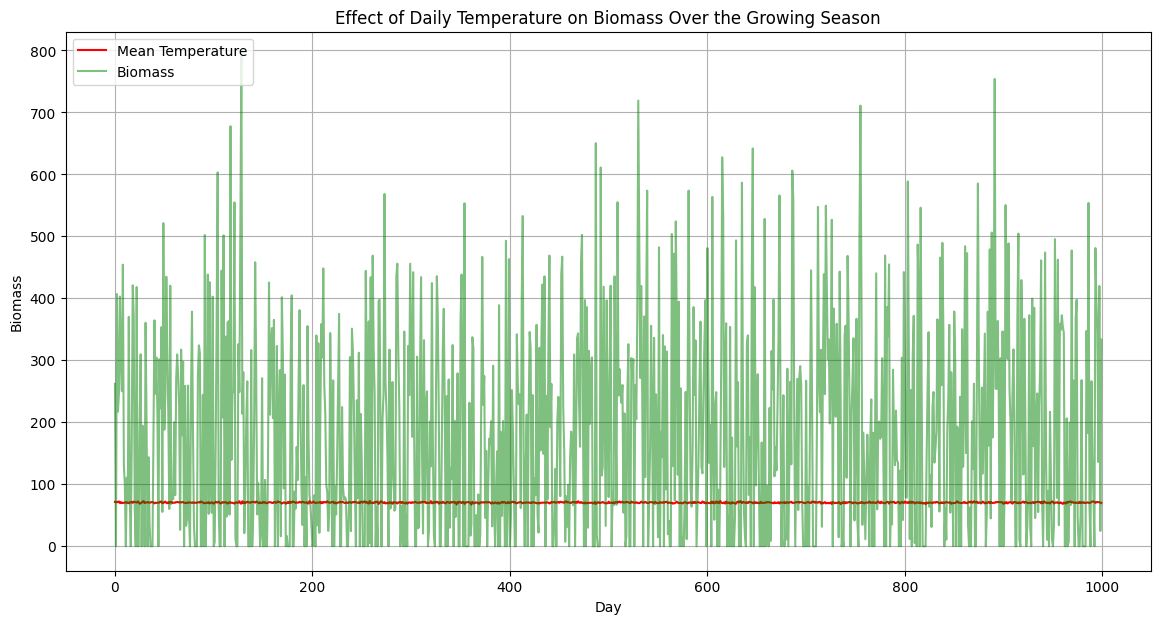

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))

# Plotting temperature
plt.plot(temperature_mean_list, 'r-', label='Mean Temperature')

# Plotting biomass growth to observe its correlation with temperature effect
plt.plot(final_biomass_list, 'g-', label='Biomass', alpha=0.5)

plt.xlabel('Day')
plt.ylabel('Biomass')
plt.title('Effect of Daily Temperature on Biomass Over the Growing Season')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

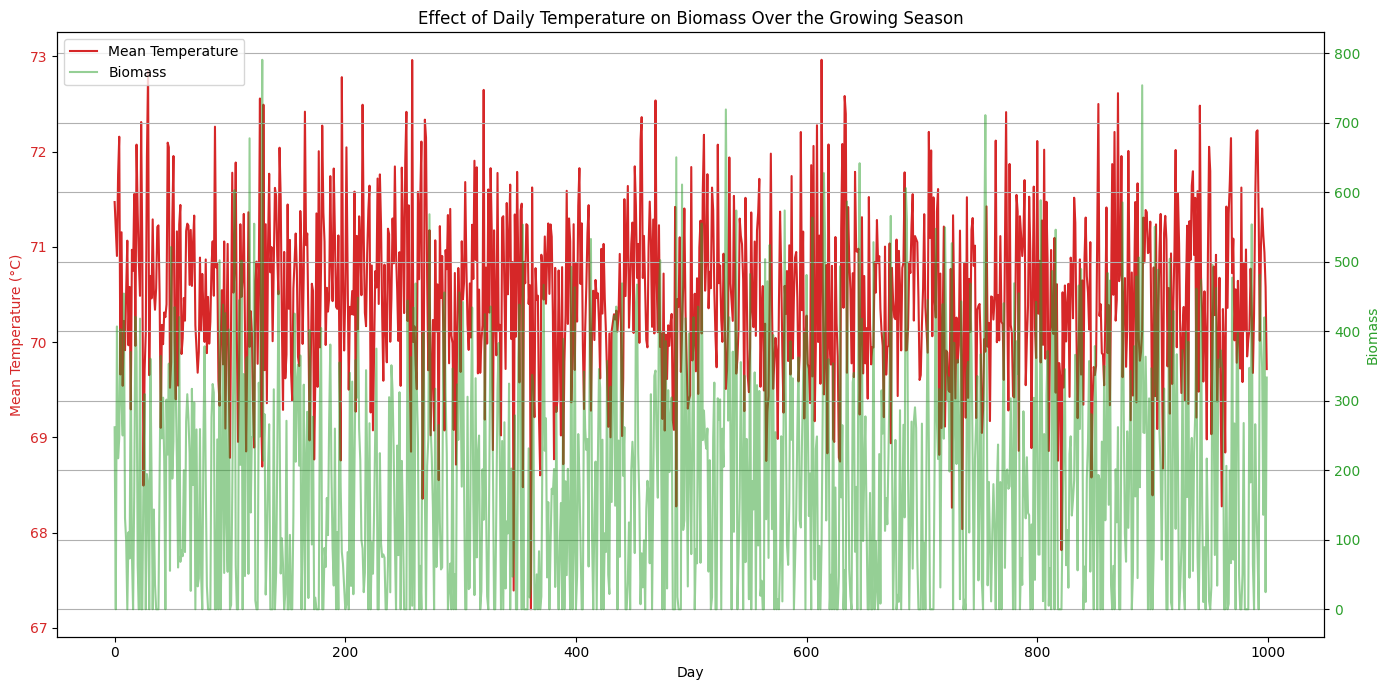

In [4]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting temperature on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('Mean Temperature (°C)', color=color)
ax1.plot(temperature_mean_list, color=color, label='Mean Temperature')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the biomass plot
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Biomass', color=color)
ax2.plot(final_biomass_list, color=color, label='Biomass', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

# Title and grid
plt.title('Effect of Daily Temperature on Biomass Over the Growing Season')
fig.tight_layout()
plt.grid(True)

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


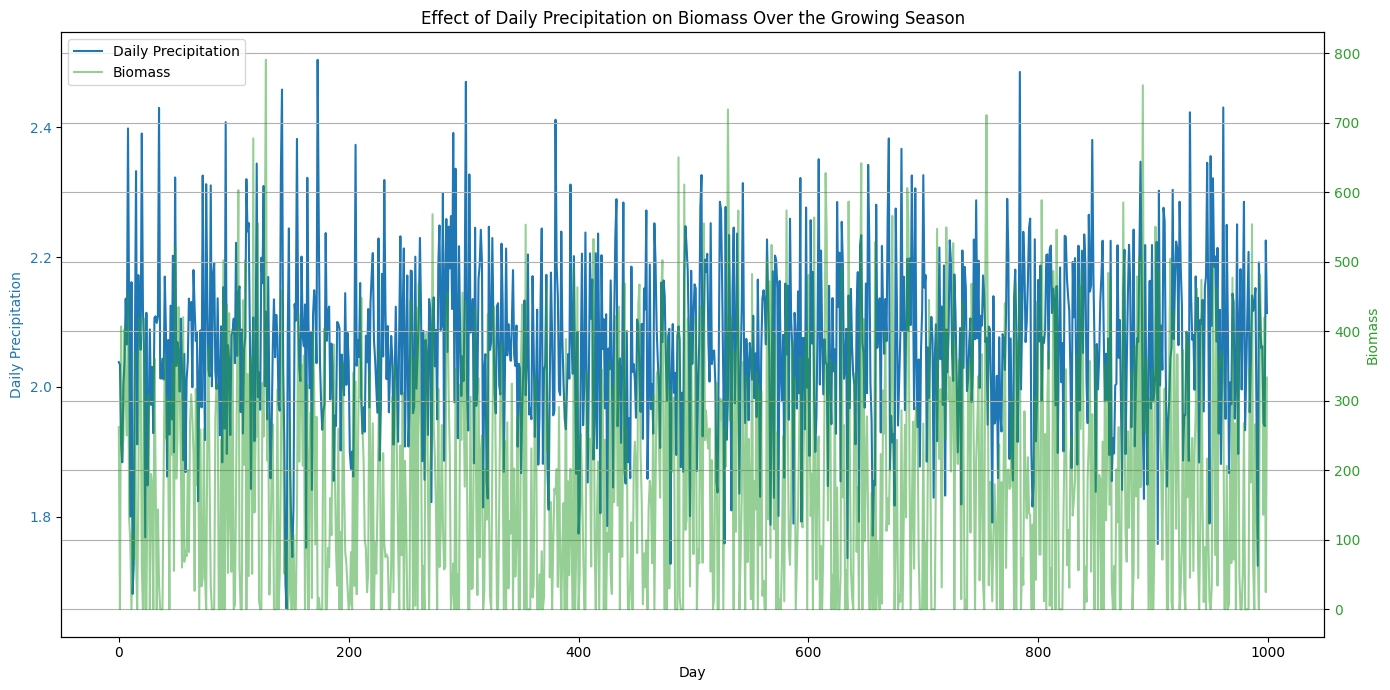

In [5]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting tthe daily precipitation on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Daily Precipitation', color=color)
ax1.plot(daily_precipitation_mean_list, color=color, label='Daily Precipitation')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the biomass plot
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Biomass', color=color)
ax2.plot(final_biomass_list, color=color, label='Biomass', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

# Title and grid
plt.title('Effect of Daily Precipitation on Biomass Over the Growing Season')
fig.tight_layout()
plt.grid(True)

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

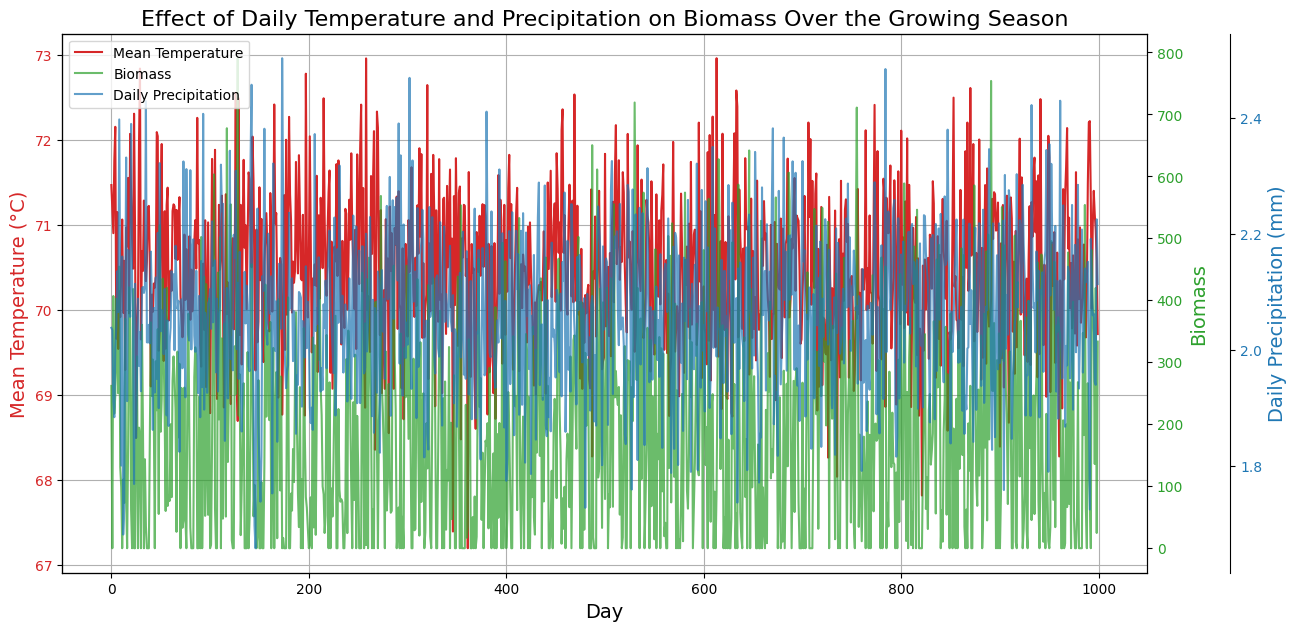

In [6]:
import matplotlib.pyplot as plt

# Create a figure and a base subplot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting temperature on the primary y-axis
color_temp = 'tab:red'
ax1.set_xlabel('Day', fontsize=14)
ax1.set_ylabel('Mean Temperature (°C)', color=color_temp, fontsize=14)
ax1.plot(temperature_mean_list, color=color_temp, label='Mean Temperature')
ax1.tick_params(axis='y', labelcolor=color_temp)
ax1.grid(True)

# Create a second y-axis for the biomass plot
ax2 = ax1.twinx()
color_biomass = 'tab:green'
ax2.set_ylabel('Biomass', color=color_biomass, fontsize=14)
ax2.plot(final_biomass_list, color=color_biomass, label='Biomass', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color_biomass)

# Create a third y-axis for the daily precipitation plot
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color_precip = 'tab:blue'
ax3.set_ylabel('Daily Precipitation (mm)', color=color_precip, fontsize=14)
ax3.plot(daily_precipitation_mean_list, color=color_precip, label='Daily Precipitation', alpha=0.7)
ax3.tick_params(axis='y', labelcolor=color_precip)

# Adding legends from all three axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')

plt.title('Effect of Daily Temperature and Precipitation on Biomass Over the Growing Season', fontsize=16)
plt.show()


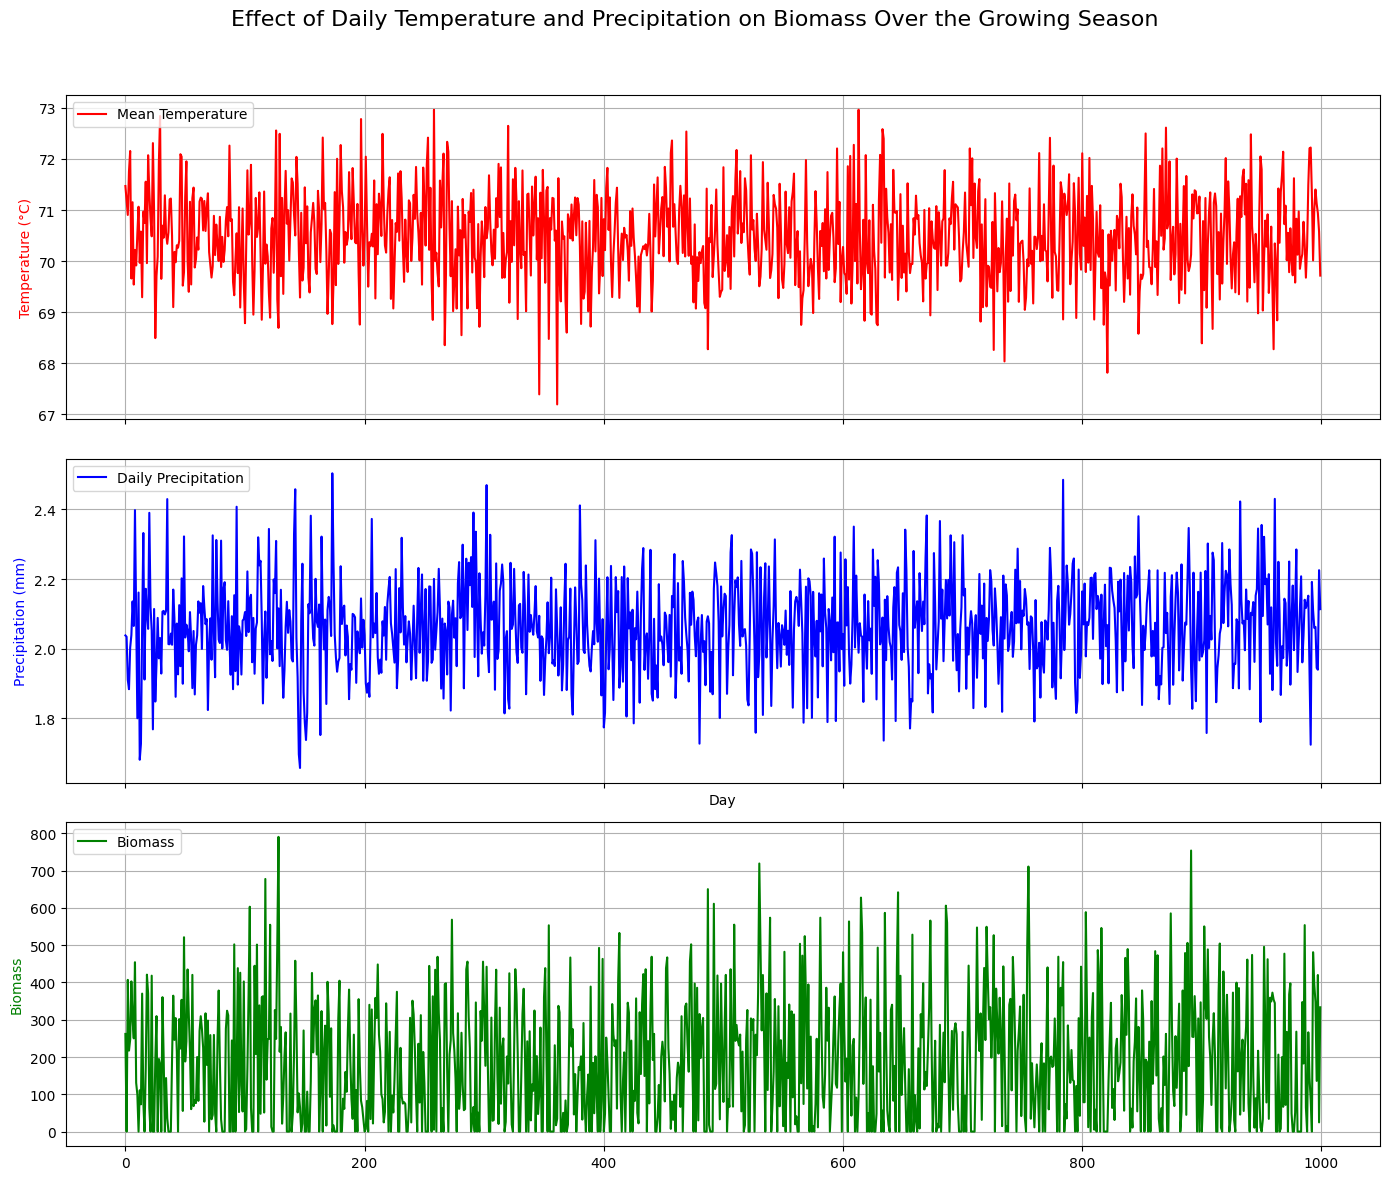

In [7]:
import matplotlib.pyplot as plt

# Create a figure and three subplots, sharing the x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# First subplot for Temperature
ax1.plot(temperature_mean_list, 'r-', label='Mean Temperature')
ax1.set_ylabel('Temperature (°C)', color='r')
ax1.legend(loc='upper left')
ax1.grid(True)

# Second subplot for Precipitation
ax2.plot(daily_precipitation_mean_list, 'b-', label='Daily Precipitation')
ax2.set_ylabel('Precipitation (mm)', color='b')
ax2.set_xlabel('Day')
ax2.legend(loc='upper left')
ax2.grid(True)

# Third subplot for Biomass
ax3.plot(final_biomass_list, 'g-', label='Biomass')
ax3.set_ylabel('Biomass', color='g')
ax3.legend(loc='upper left')
ax3.grid(True)

# Add a title to the figure
fig.suptitle('Effect of Daily Temperature and Precipitation on Biomass Over the Growing Season', fontsize=16)

# Adjust the layout to make sure there's no overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()
